In [34]:
import os, sys
root_dir = os.path.abspath("..")
sys.path.insert(0, root_dir)
import lib.main # type: ignore
import lib

# Introduction

Since the project is getting large, we decided to implement it in a gitlab repository with up to 10gb of free space. We have a proper conda/python setup for developing the project, with a project-specific conda environment. Also, most of the code is generic and reusable, and we can easily try out new things/ideas.

In order to setup the project from scratch you need to do the following (you need to use linux or wsl).
* Clone the repo: https://gitlab.com/williamMBDK/data-science-project
* Make sure conda (miniconda) is installed.
* setup conda environment: source ./scripts/setup
* activate conda environment (must be done for every new terminal unless you use direnv):
    * source ./scripts/activate
* run: ./bin/setupdatabase
* optionally run (it randomly samples from the whole dataset): ./bin/largedataset
* optionally run (it cleans and does data integration of the fake news data): ./bin/fakenewscorpus-DI
* run: ./bin/loaddata
* now this notebook will be runnable if you have activated the environment and run ./script/notebookserver.

# Task 1

#### Schema design:
First of all, we wanted the schema to capture the fact that an article can have multiple authors. We therefore started by drawing the following ER-diagram:

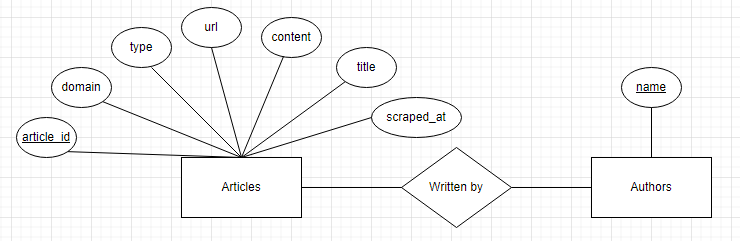
Here we have a many-to-many relationship between authors and articles to capture the fact that an article can be written by several authors, and an author can have written several articles. From the ER-diagram we derived the following relations:

#### articles relation:

articles(__article_id__, type, title, url, domain, content, scraped_at)

#### author relation:

authors(__author_id__, name)

#### Writtenby relation:

written_by(__article_id__, __author_id__)

The reason we have "ON DELETE CASCADE" is because when an article gets deleted, we want the writtenby relation associated to that article to be deleted aswell, since it doesn't make sense to keep information about who wrote an article if the article doesn't exist in the database. 

In [35]:
#Size of articles table: 8368
print("Size of articles table:")
lib.db.query("""select COUNT(article_id) FROM articles""")

#Size of writtenby table: 14436
print("\nSize of writtenby table:")
lib.db.query("""select COUNT(author_id) FROM writtenby""")

#Size of authors table: 3933
print("\nSize of authors table:")
lib.db.query("""select COUNT(author_id) FROM authors""")

#Simple query: Extracting first 10 rows
print("\nSimple query: Extracting first 10 rows:")
print("Type, Domain")
lib.db.query("""SELECT DISTINCT type, domain
                FROM articles
                FETCH FIRST 10 ROWS ONLY;""")

Size of articles table:
Number of rows:  1
(8368,)

Size of writtenby table:
Number of rows:  1
(14436,)

Size of authors table:
Number of rows:  1
(3933,)

Simple query: Extracting first 10 rows:
Type, Domain
Number of rows:  10
('satire', 'theonion.com')
('reliable', 'www.theguardian.com')
('unknown', 'freebeacon.com')
('unknown', 'www.ammoland.com')
('unknown', 'tyronetribulations.com')
('fake', 'thetruthdivision.com')
('bias', 'wnd.com')
('conspiracy', 'infowars.com')
('satire', 'waterfordwhispersnews.com')
('conspiracy', 'thephaser.com')


Note we had to download/upload the datasets over EU-roaming, so we decided to just use around 10000 rows.

# Task 2

The relations are (as listed before):

#### articles relation:
CREATE TABLE IF NOT EXISTS articles ( <br>
article_id BIGSERIAL,<br>
type VARCHAR(255) NOT NULL,<br>
title VARCHAR(4095) NOT NULL,<br>
url VARCHAR(4095) NOT NULL,<br>
domain VARCHAR(255) NOT NULL,<br>
content VARCHAR NOT NULL,<br>
scraped_at TIMESTAMP NOT NULL,<br>
PRIMARY KEY (article_id)<br>

#### author relation:
CREATE TABLE IF NOT EXISTS authors (<br>
author_id BIGSERIAL,<br>
name VARCHAR(255) NOT NULL UNIQUE,<br>
PRIMARY KEY (author_id)<br>

#### Writtenby relation:
CREATE TABLE IF NOT EXISTS writtenby (<br>
article_id int REFERENCES Articles(article_id)<br>
ON DELETE CASCADE<br>
ON UPDATE CASCADE<br>
DEFERRABLE INITIALLY DEFERRED,<br>
author_id int REFERENCES Authors(author_id)<br>
ON DELETE CASCADE<br>
ON UPDATE CASCADE<br>
DEFERRABLE INITIALLY DEFERRED,<br>
PRIMARY KEY (article_id, author_id)<br>

The reason we have "ON DELETE CASCADE" is because when an article gets deleted, we want the writtenby relation associated to that article to be deleted aswell, since it doesn't make sense to keep information about who wrote an article if the article doesn't exist in the database.

From which the atrributes and primary keys can be seen.
#### Functional dependencies articles relation:
The functional dependencies of the articles relation are: <br>
F={id → ty-ti-ur-do-co, url → domain}
<br>
(attributes are seperated by an - for easier readability. Attributes are also shortened, ty = type, ti = title and so on)<br>
Here, the first functional dependency does not make the relation violate BCNF form, since articles_id is a key. However, the second functional dependency does make the relation violate BCNF form, since url is not a key because one url could, in theory, contain multiple articles. Url → domain is a functional dependency because the domain is just a substring of the url (i.e. we can obtain the domain directly from url). Not having the relations in BCNF form could create anomalies in the tables. Forexample, if we were to update the domain of an article instance to an entirely different domain (but not change the url), then we would have an anomaly. We would have to make sure that we update the url and domain together.

To get BCNF form we would therefore have to split the articles into two seperate relations. The first relation would be the articles relation but without domain, and the second would contain "url" and "domain" as attributes.

#### Functional dependencies authors relation:
Functional dependencies for authors relation: F={author_id → name}
This relation is in BCNF form since author_id is a key.

#### Functional dependencies writtenby relation:
The functional dependency for the writtenby relation is a trivial functional dependency: F={author_id-article_id → author_id-article_id}
Therefore, this relation is also in BCNF form.

# Task 3


The first query will look the following in relation algebra:

π domain (σ scraped_at ≥ "January 15, 2018" ∧ type = "reliable" (articles))

Note, the uniqueness constraint is implied in standard relational algebra.

The second query will look the following in extended relation algebra.

max_authors := γ author_id, name; COUNT(articled_id) → cnt (σ type = "fake" ((authors ⨝ writtenby) ⨝ articles))
max_author_cnt := π MAX(cnt) (max_authors) -- is this extended projection?
π name, cnt (σ cnt=max_author_cnt (max_authors))

however for the second line we are unsure if it is extended projection or not. Otherwise we have to use the trick where we make a relation with every author compared to every other author based on whether the count is greater than, and select the author which is compared to everyone.

In [36]:
#The column names can be seen above "Number of rows: " in the print statement
#Query 1
print("Query1:\nDomain name")
lib.db.query("""SELECT DISTINCT domain
                FROM articles
                WHERE type = 'reliable' AND scraped_at >= 'January 15 2018'
                """)
#Query 2
# This query sorts the authors by number of fake articles
print("\nAuthors sorted by number of fake articles (query 2):\nName, Number of fake articles")
lib.db.query("""SELECT name,num_fake_articles
                FROM authors
                INNER JOIN (SELECT author_id, COUNT(type) AS num_fake_articles
                FROM (SELECT * FROM articles INNER JOIN writtenby ON writtenby.article_id = articles.article_id)
                result
                WHERE result.type = 'fake'
                GROUP BY result.author_id) result
                ON authors.author_id = result.author_id
                ORDER BY num_fake_articles DESC;
            """)

# This query selects the most profilic authors
print("\nQuery2:\nName, Number of fake articles")
lib.db.query("""SELECT name, cnt
                FROM (
                    SELECT name, COUNT(article_id) AS cnt
                    FROM (authors NATURAL INNER JOIN writtenby) NATURAL INNER JOIN articles
                    WHERE type='fake'
                    GROUP BY author_id) namecnt
                WHERE namecnt.cnt = (SELECT MAX(namecnt.cnt) FROM (
                    SELECT COUNT(article_id) AS cnt
                    FROM (authors NATURAL INNER JOIN writtenby) NATURAL INNER JOIN articles
                    WHERE type='fake'
                    GROUP BY author_id
                ) namecnt);
            """)

#Query 3
#Our relation does not have a “meta-keywords” attribute,
#as most of the rows from the dataset were missing them,
#so we decided to clean that column in milestone 1.
#The followng SQL query does not work,
#since we don’t have the attribute in our relation,
#but it is the query we would have used to complete the task.

#SELECT SUM(duplicates)
#FROM
#(SELECT type, COUNT(meta_keywords) AS duplicates
#FROM articles
#GROUP BY meta_keywords) AS dup_rel
#WHERE dup_rel.duplicates != 1;

Query1:
Domain name
Number of rows:  3
('nutritionfacts.org',)
('christianpost.com',)
('nytimes.com',)

Authors sorted by number of fake articles (query 2):
Name, Number of fake articles
Number of rows:  455
('sound of heart - galactic free press', 10)
('the daily sheeple', 10)
('zacks investment research', 9)
('john rolls', 7)
('alton parrish', 7)
('eyes for you', 5)
('dr. orly taitz esquire', 5)
('universe today', 5)
('ye olde false flag', 5)
('philosophers stone', 5)

Query2:
Name, Number of fake articles
Number of rows:  2
('sound of heart - galactic free press', 10)
('the daily sheeple', 10)


# Task 4
In milestone one, we made the following observations:
#### 1. Every article from beforeitsnews.com is labeled as 'fake'
#### 2. Every article labeled 'conspiracy' has an author attached
#### 3. Every article from canadafreepress.com is labeled as a 'conspiracy'
The code below uses SQL queries to verify/disprove these claims.

In [37]:
#Query 1
print("Query 1:\nType, Number of articles of type")
lib.db.query("""SELECT  type, COUNT(type)
                FROM articles
                WHERE domain = 'beforeitsnews.com' OR domain = 'www.beforeitsnews.com'
                GROUP BY type;
            """)
#Query 2
print("\nQuery 2:\narticle_id")
lib.db.query("""SELECT url
                FROM articles
                WHERE type = 'conspiracy' AND not article_id 
                in (SELECT article_id FROM writtenby);
            """)
#Query 3
print("\nQuery 3:\nType, Number of articles of type")
lib.db.query("""SELECT type, COUNT(type)
                FROM articles
                WHERE domain = 'canadafreepress.com' OR domain = 'www.canadafreepress.com'
                GROUP BY type;
            """)

Query 1:
Type, Number of articles of type
Number of rows:  1
('fake', 803)

Query 2:
article_id
Number of rows:  446
('https://wikispooks.com/wiki/Special:SearchByProperty/Has-20fullPageNamee/Biologist',)
('http://theeconomiccollapseblog.com/archives/tag/finances',)
('http://www.whatdoesitmean.com/index1482.htm',)
('https://wikispooks.com/wiki/Special:Browse/E.-20Clay-20Shaw-23_QUERYdc52be38296032ceb659ba8da221848c',)
('https://wikispooks.com/wiki/Special:Browse/Avi-20Dichter-23_QUERYde7bffaa894dfacf40d30e936b51f8a2',)
('https://wikispooks.com/wiki/Special:Browse/Andreas-20Z%27Graggen-23_QUERYd6c89f4bb3dfceb22a6b955758e73a48',)
('https://wikispooks.com/wiki/Special:SearchByProperty/Display-20date/11-20November-20-5B-5B2013-5D-5D-20-2D-206-20May-20-5B-5B2015-5D-5D',)
('https://www.activistpost.com/2015/12/saudi-princess-speaks-out-against-chemtrails-and-geoengineering.html',)
('https://wikispooks.com/wiki/Special:SearchByProperty/Has-20wikipediaPage/https:-2F-2Fen.wikipedia.org-2Fwiki-2

#### 1. Every article from beforeitsnews.com is labeled as 'fake'
The first query only returns the number of articles labeled 'fake', meaning there are no other types of articles from the domain "beforeitsnews.com". So this claim still holds on this new dataset.
#### 2. Every article labeled 'conspiracy' has an author attached
The second query returns 446 articles labeled 'conspiracy' which have no author attached. Therefore this claim is false on this dataset.
#### 3. Every article from canadafreepress.com is labeled as a 'conspiracy'
The third query returns only returns the number of articles labeled 'conspiracy', meaning there are no other types of articles from the domain "canadafreepress.com". So this claim still holds on this new dataset